##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.3.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

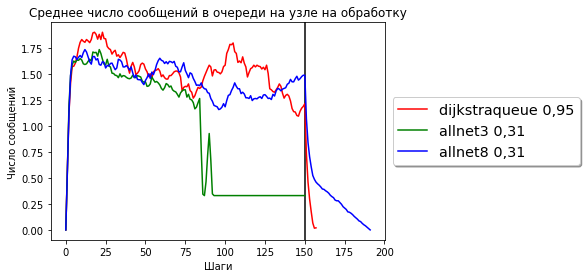

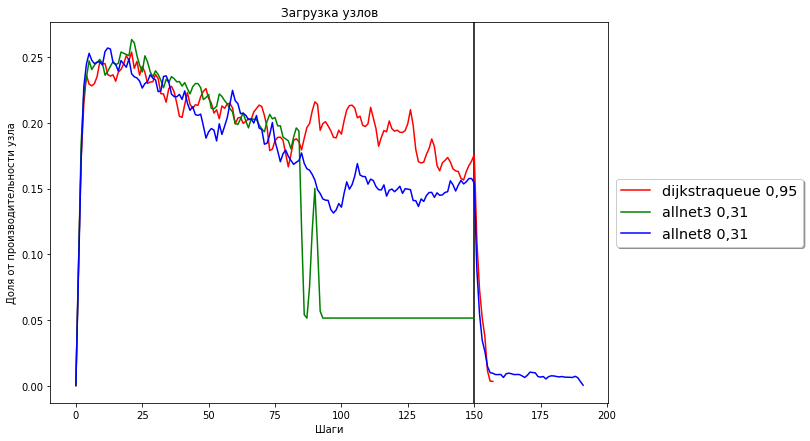

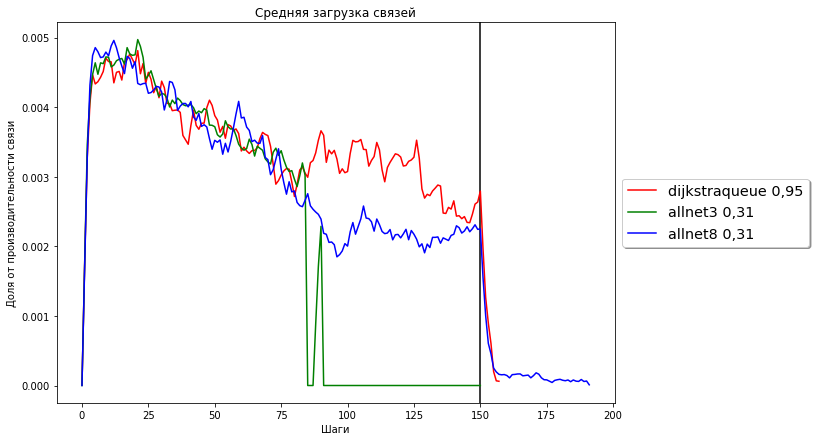

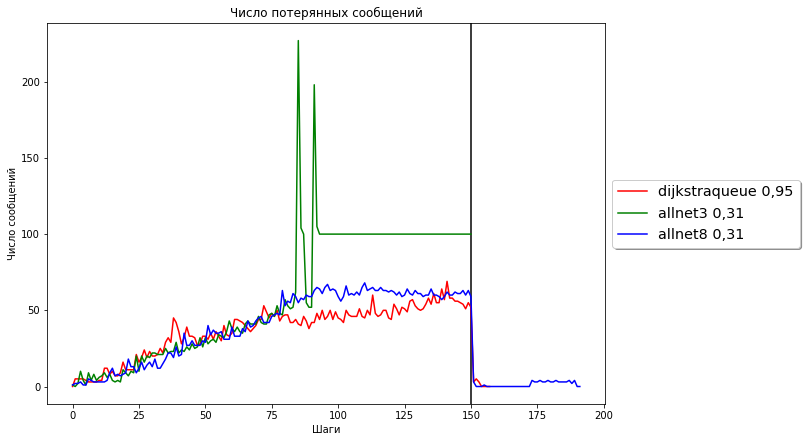

Доставлено 9361 Потеряно 37.5975% -dijkstraqueue 0,95
Доставлено 6126 Потеряно 59.1627% -allnet3 0,31
Доставлено 8750 Потеряно 41.6706% -allnet8 0,31


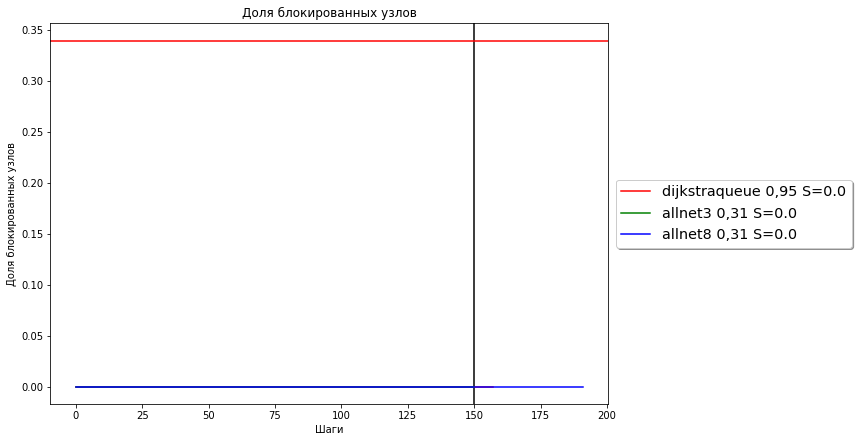

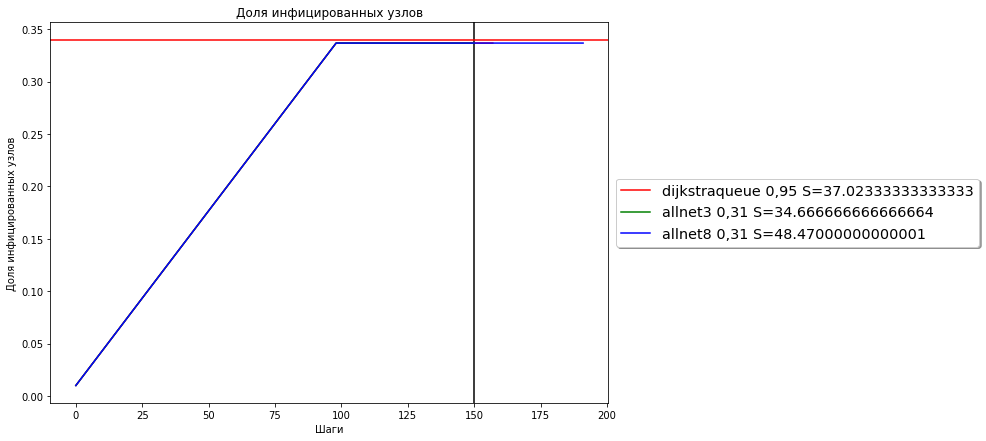

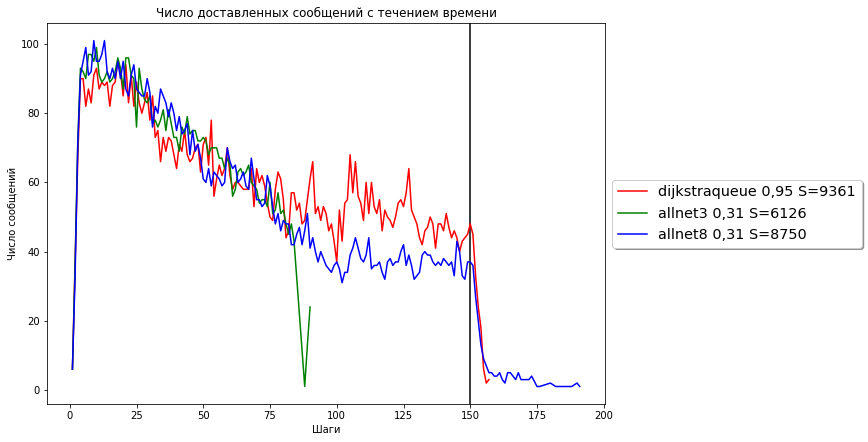

In [3]:
quantity = 100;
log_tags = [
{"tag":  "4dc9f6a4-f248-4c8d-9b37-4ec0d661a402", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "394ad6a1-a4bc-49db-92ef-c0a9c8810e21", "label": "allnet3 0,31", "color": "green"},
{"tag":  "9e2c66f5-0a45-417d-a7a9-24a67b513598", "label": "allnet8 0,31", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 500 </strong>

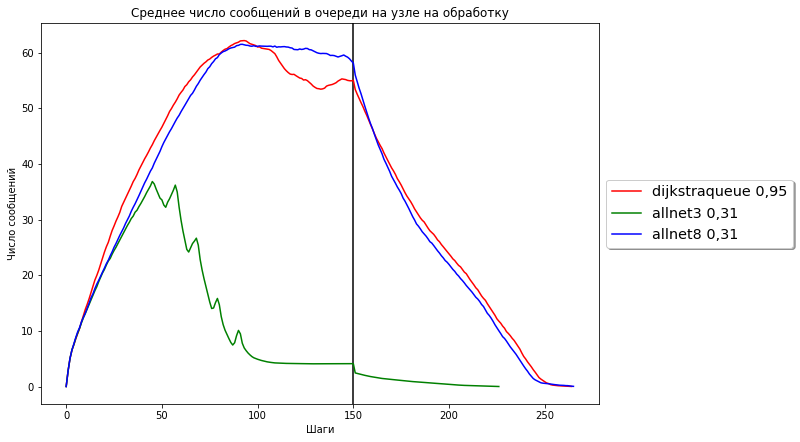

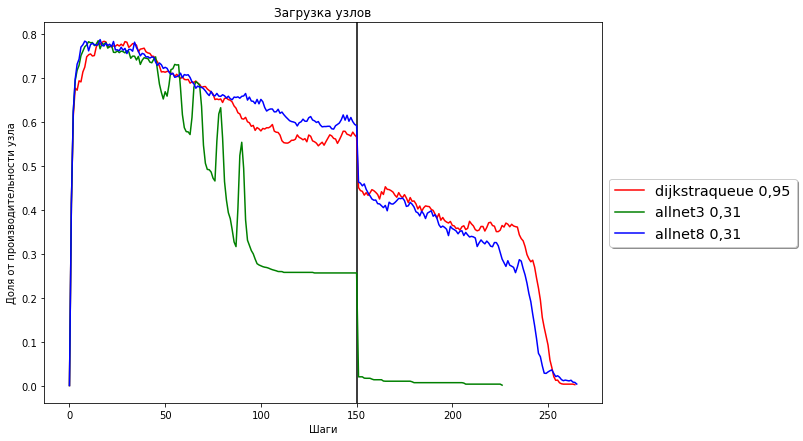

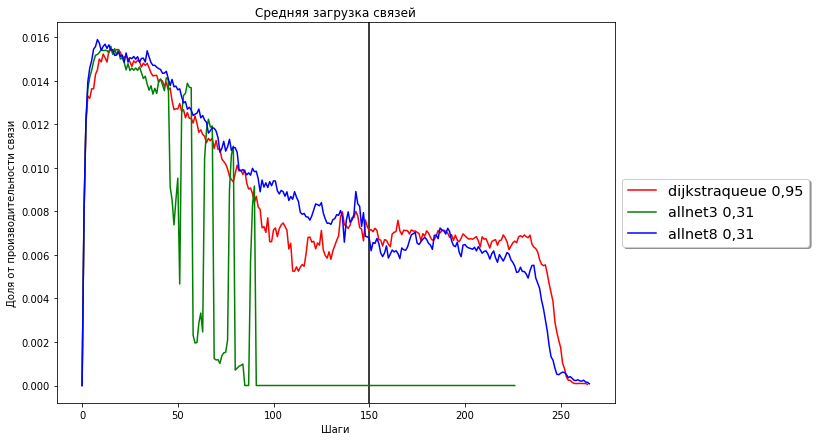

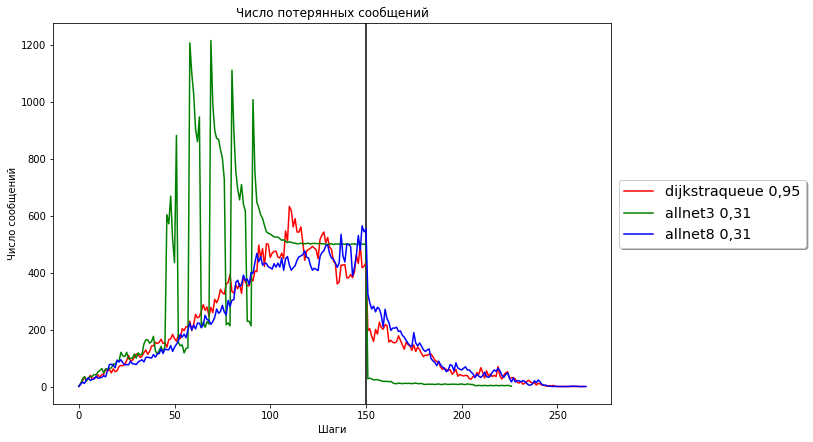

Доставлено 23121 Потеряно 69.1724% -dijkstraqueue 0,95
Доставлено 12318 Потеряно 83.5762% -allnet3 0,31
Доставлено 24364 Потеряно 67.5151% -allnet8 0,31


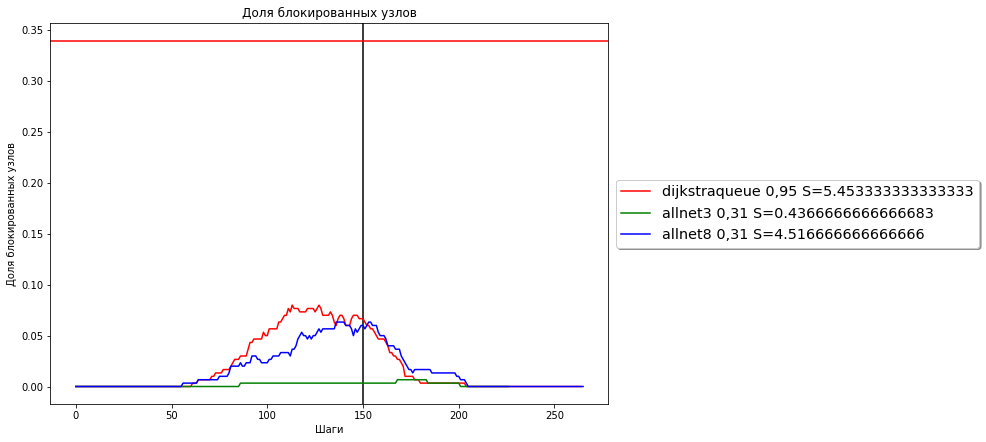

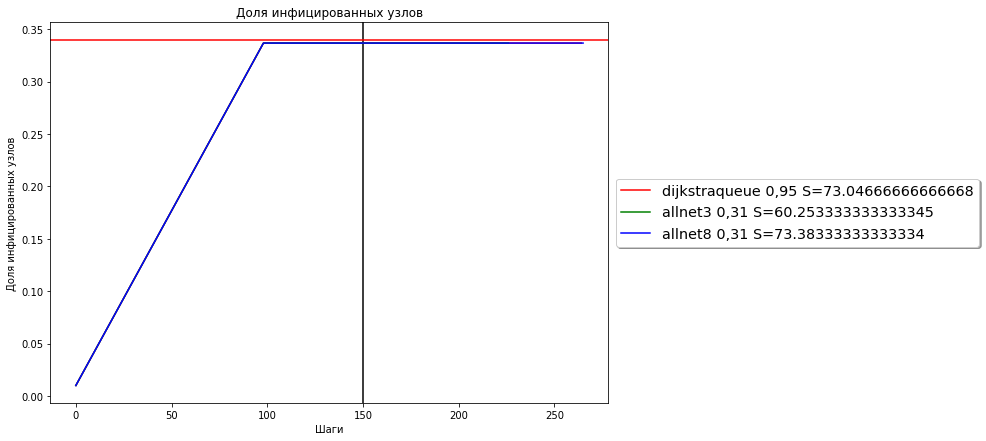

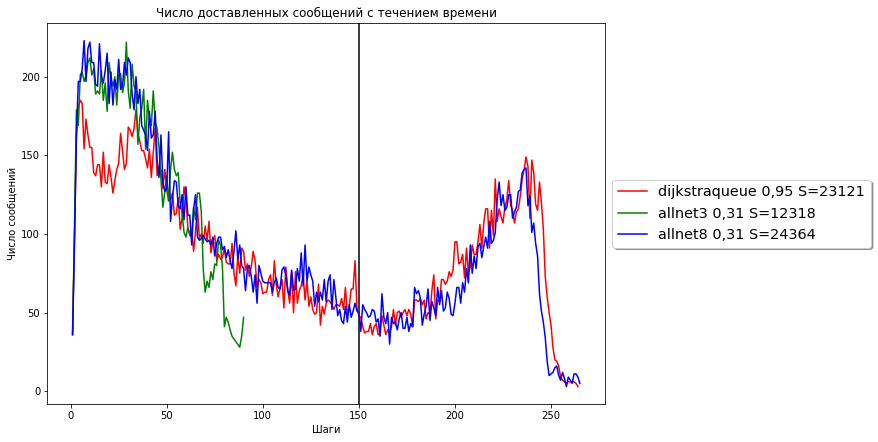

In [4]:
quantity = 500;
log_tags = [
{"tag":  "a37e4b8c-cb6a-4eea-a042-89a7df382fa5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "6bacd75c-b87e-4ffe-9546-e8cd6ad69630", "label": "allnet3 0,31", "color": "green"},
{"tag":  "6107814b-0413-42b3-b8bb-bf5892984844", "label": "allnet8 0,31", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

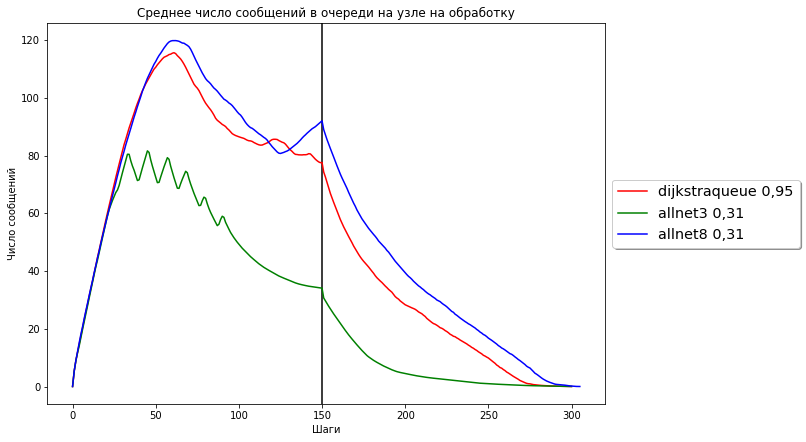

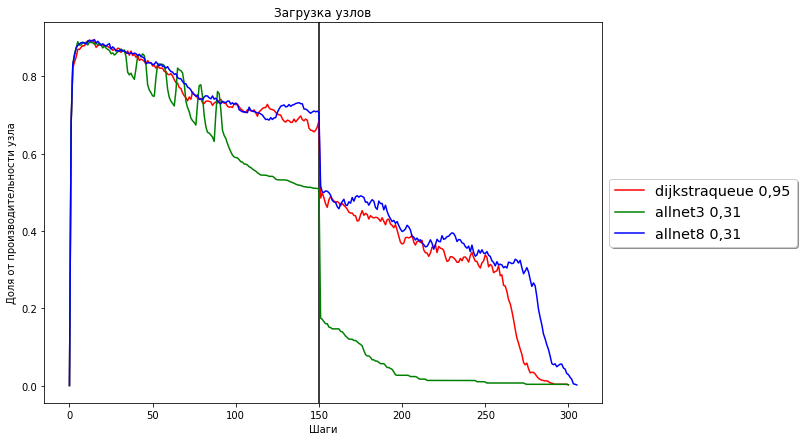

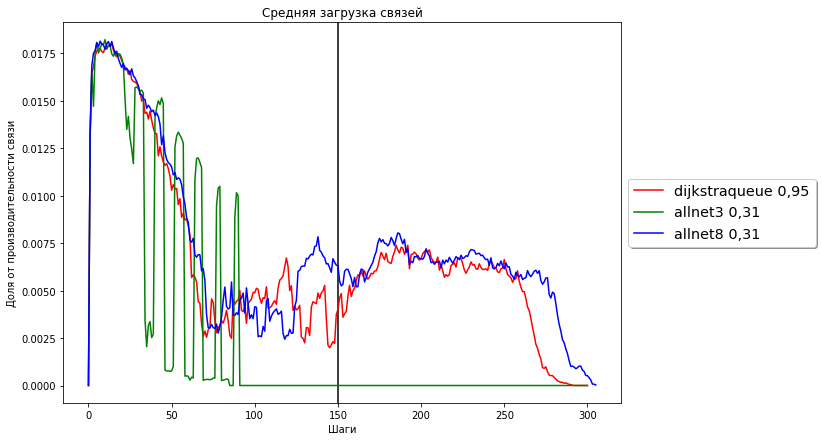

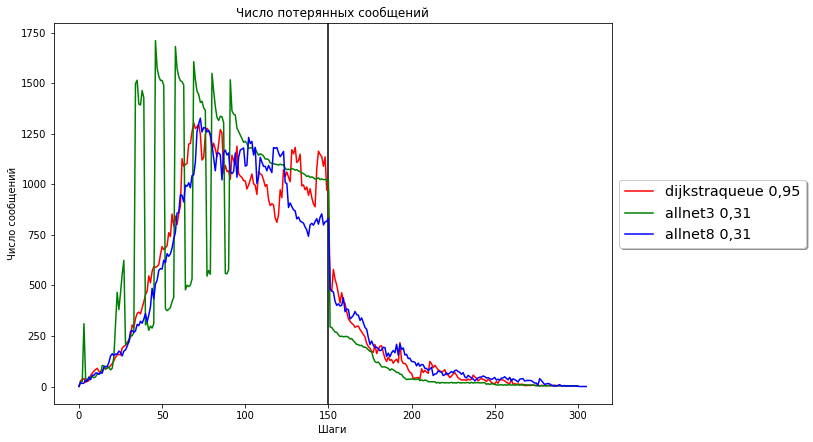

Доставлено 17536 Потеряно 88.3094% -dijkstraqueue 0,95
Доставлено 7549 Потеряно 94.9674% -allnet3 0,31
Доставлено 20453 Потеряно 86.3648% -allnet8 0,31


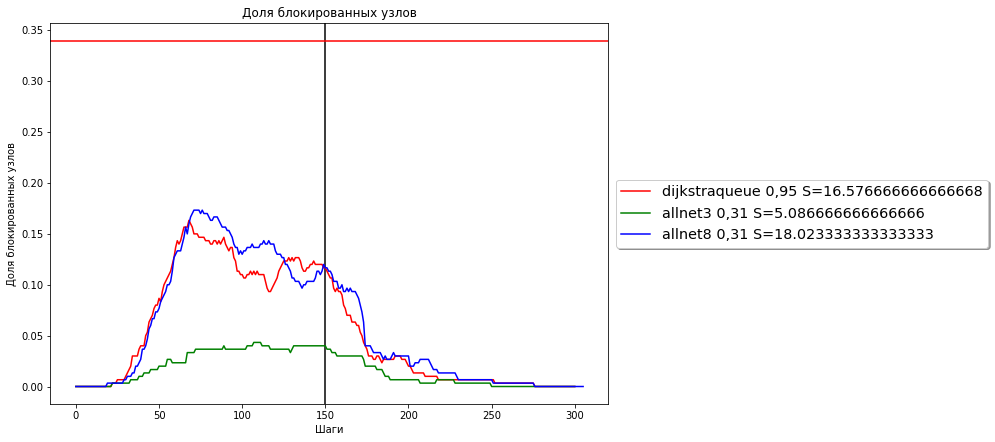

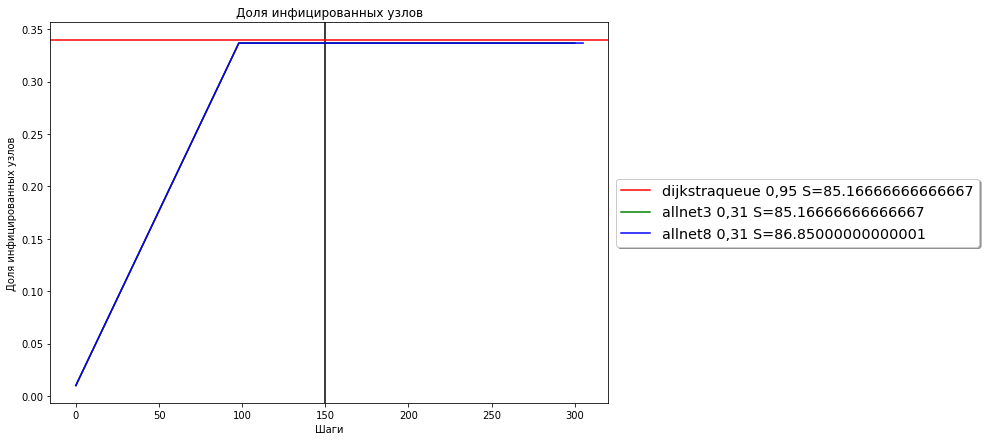

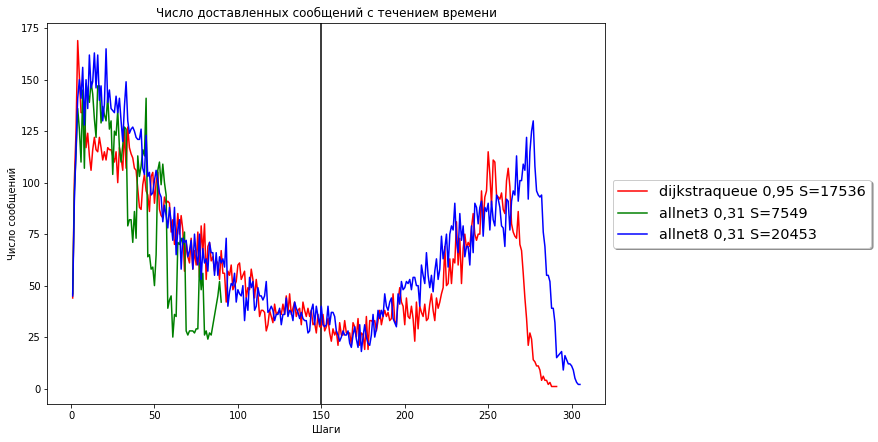

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "f87ea278-5362-4c5d-8dbe-623e344c0543", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e0336e89-25dc-4732-a428-81838fa374b9", "label": "allnet3 0,31", "color": "green"},
{"tag":  "d1c35195-fefe-420a-920d-10ee0f7fcd11", "label": "allnet8 0,31", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 1500 </strong>

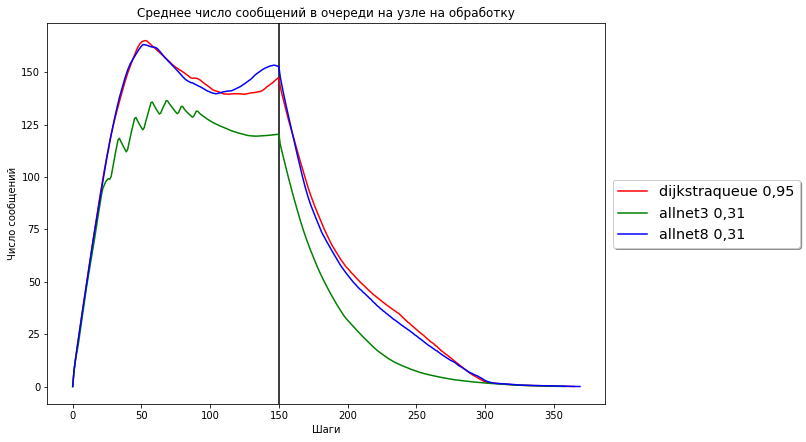

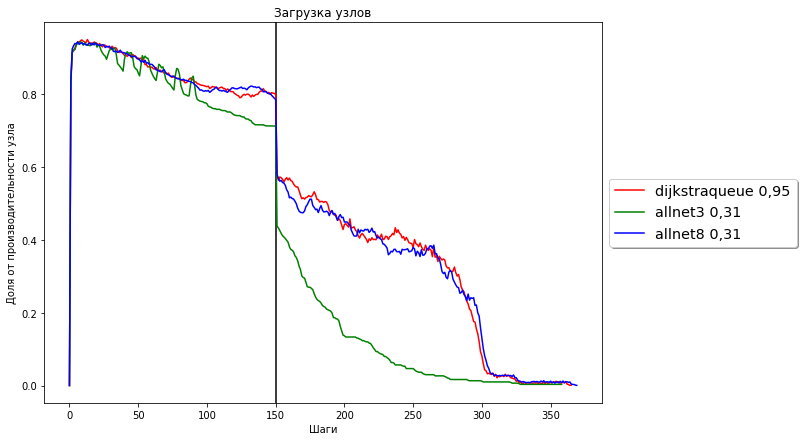

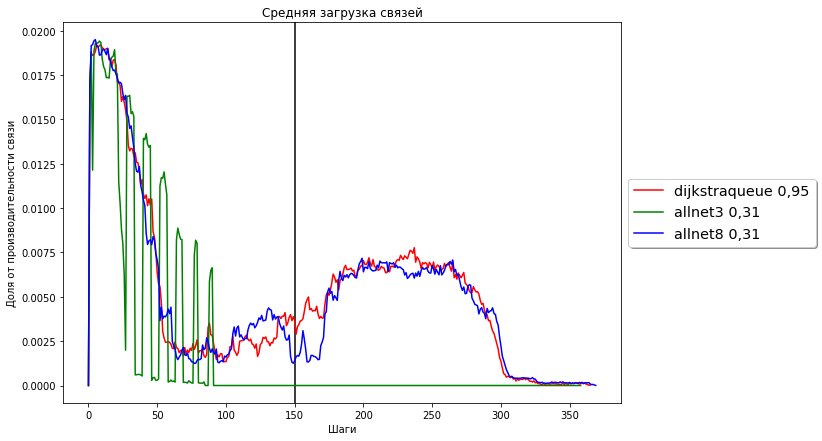

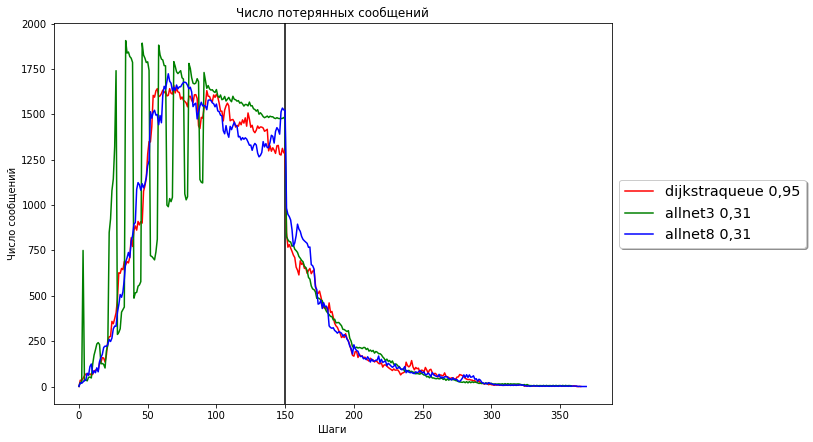

Доставлено 18408 Потеряно 91.8187% -dijkstraqueue 0,95
Доставлено 5254 Потеряно 97.6649% -allnet3 0,31
Доставлено 17201 Потеряно 92.3551% -allnet8 0,31


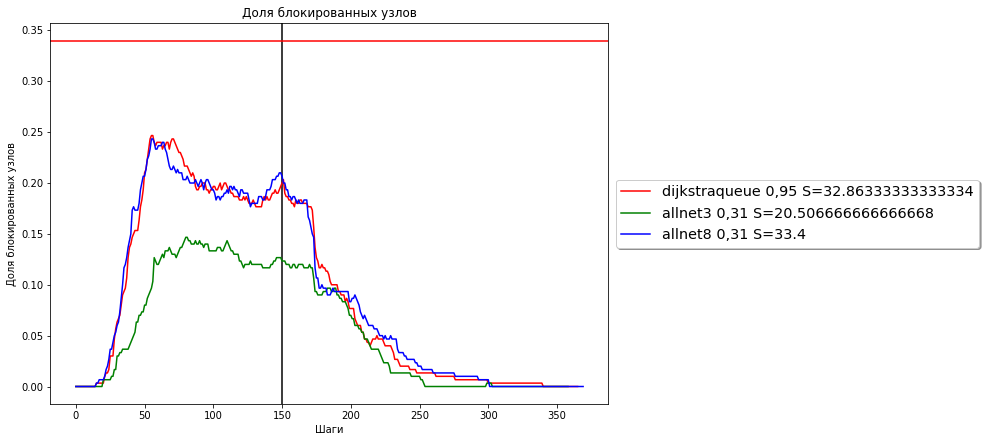

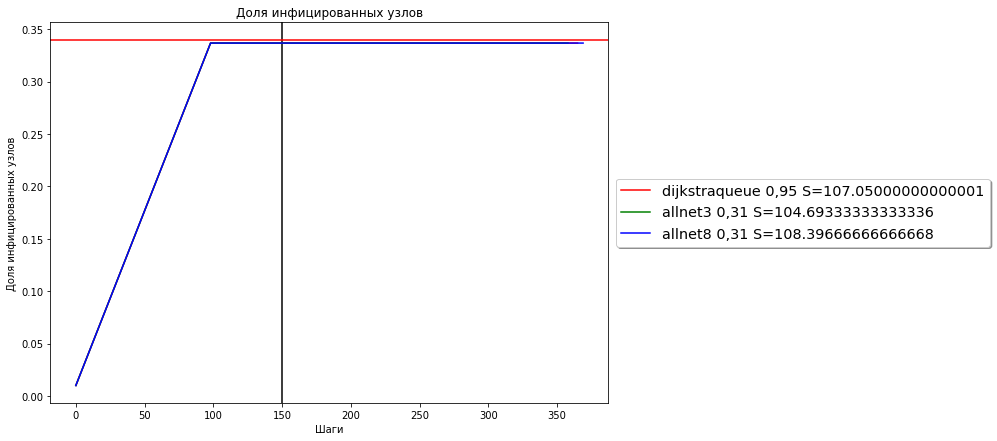

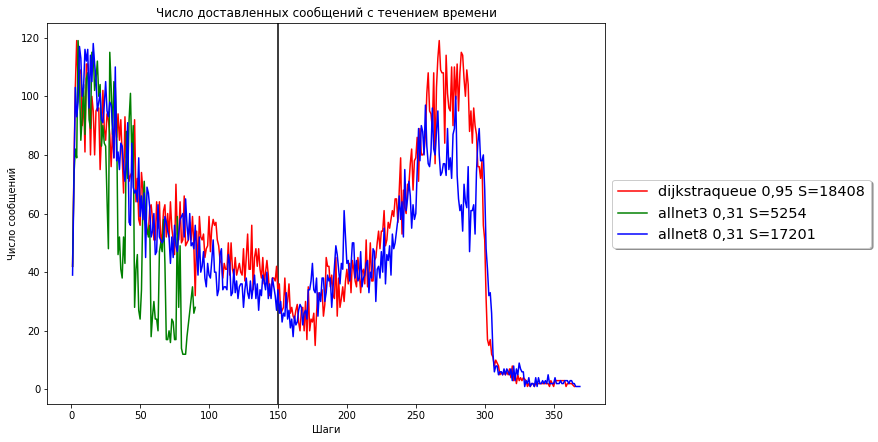

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "31747787-a5e1-466a-9880-3a01e79c4ce7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "beb546ec-4330-4c27-acf3-11c8a3c8ebd0", "label": "allnet3 0,31", "color": "green"},
{"tag":  "2ca2d2e5-a0f6-4cc5-98e6-3331cb0772f1", "label": "allnet8 0,31", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();


Доставлено 22021 Потеряно 51.0655% -dijkstraqueue 0,95
Доставлено 13891 Потеряно 69.1318% -allnet3 0,31
Доставлено 25619 Потеряно 43.0702% -allnet8 0,31


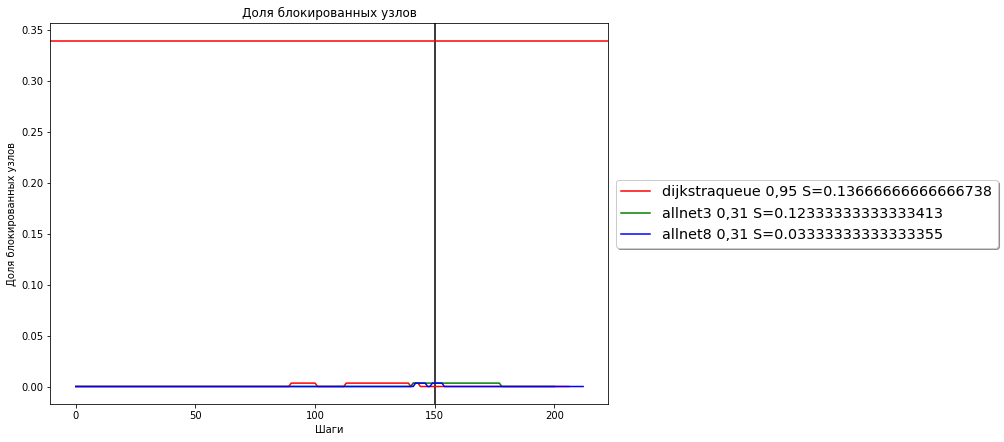

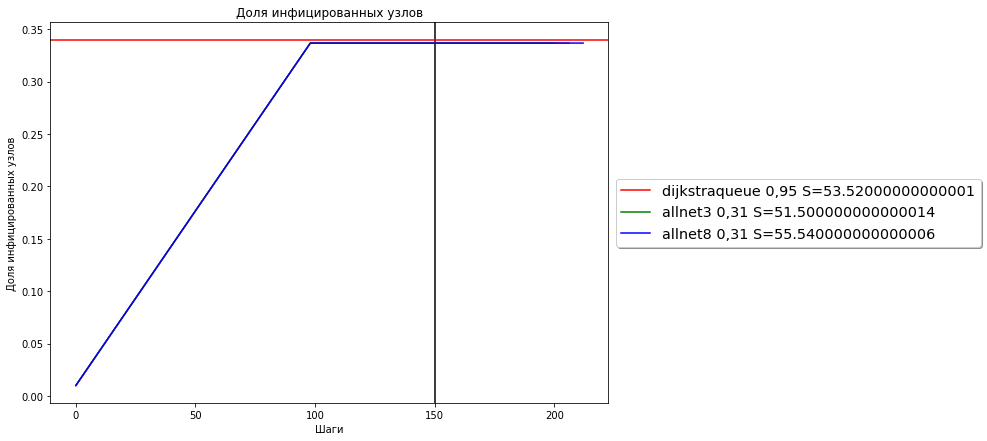

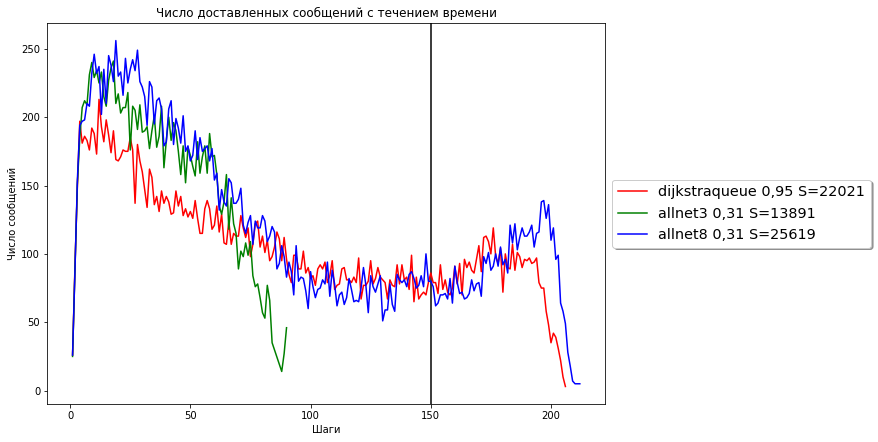

Доставлено 23027 Потеряно 78.0697% -dijkstraqueue 0,95
Доставлено 9011 Потеряно 91.4182% -allnet3 0,31
Доставлено 23199 Потеряно 77.9059% -allnet8 0,31


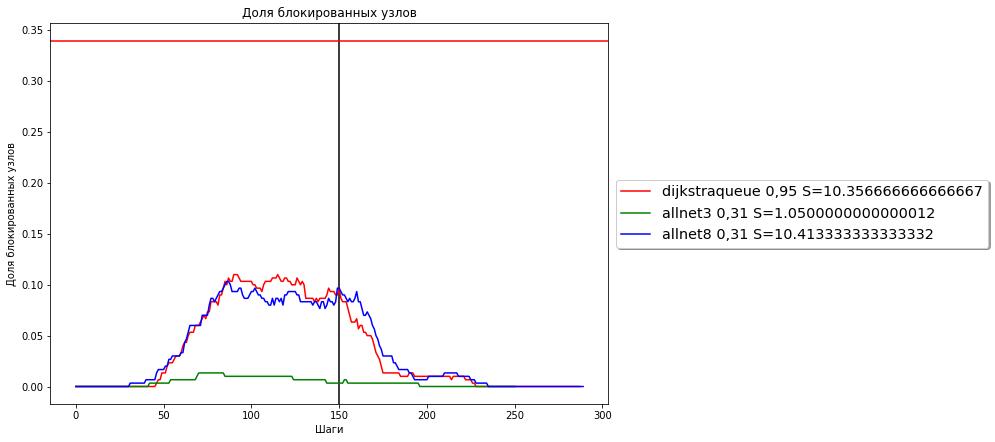

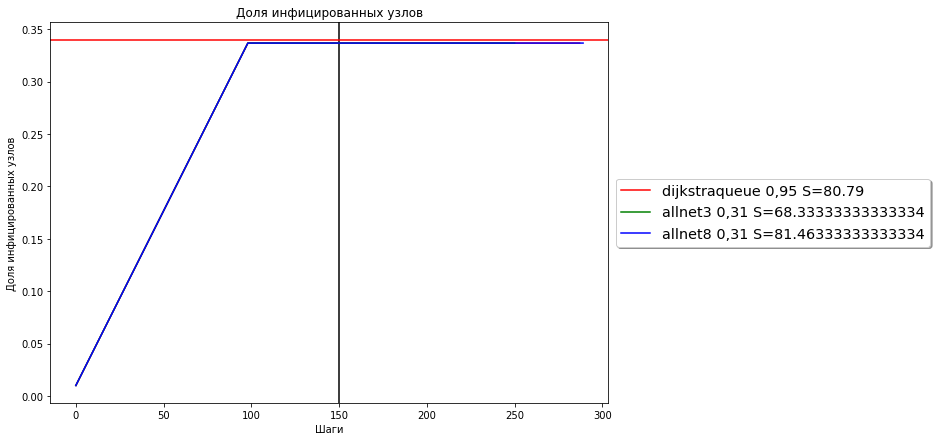

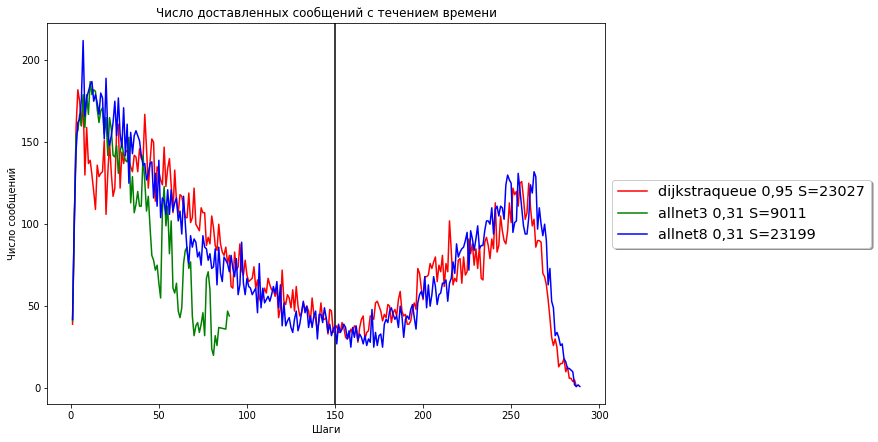

Доставлено 20271 Потеряно 84.9846% -dijkstraqueue 0,95
Доставлено 8241 Потеряно 93.8956% -allnet3 0,31
Доставлено 19891 Потеряно 85.2660% -allnet8 0,31


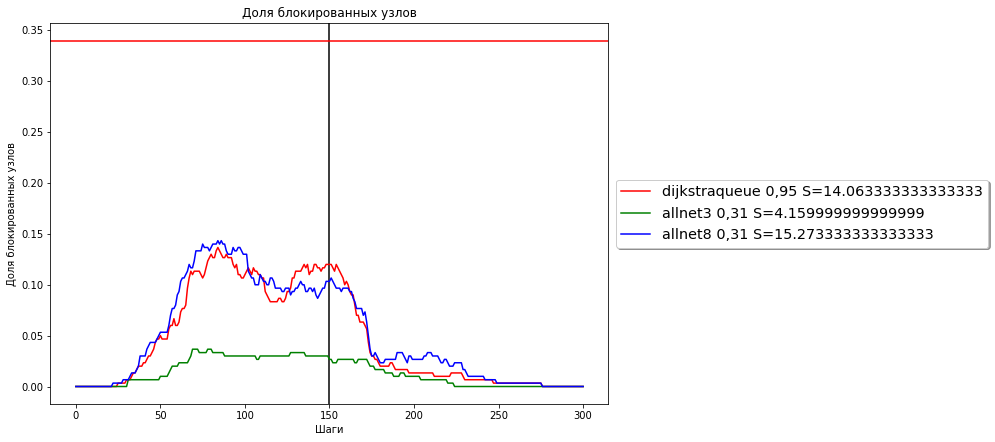

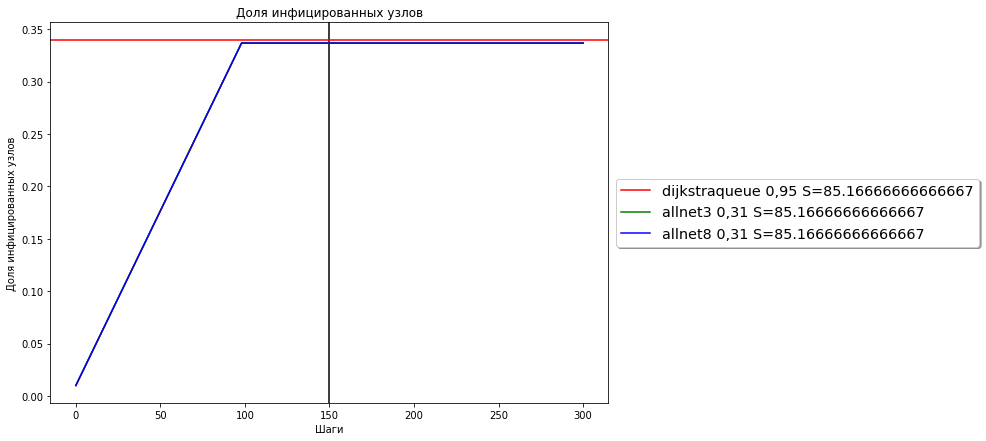

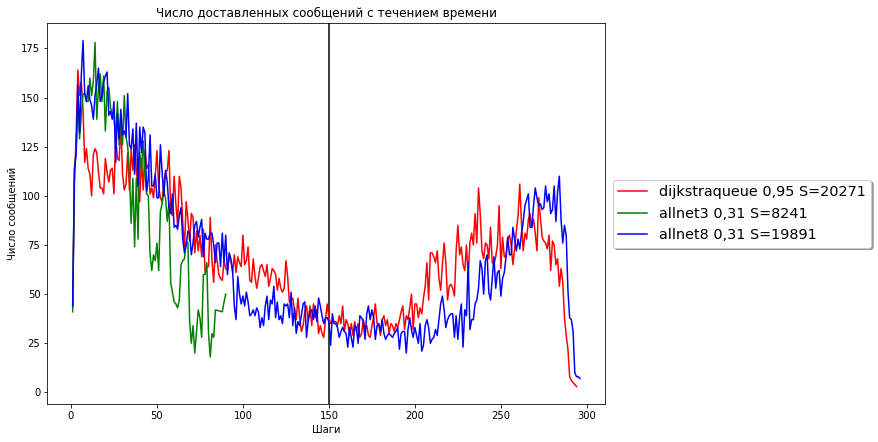

Доставлено 18318 Потеряно 90.6062% -dijkstraqueue 0,95
Доставлено 6258 Потеряно 96.7908% -allnet3 0,31
Доставлено 19929 Потеряно 89.7801% -allnet8 0,31


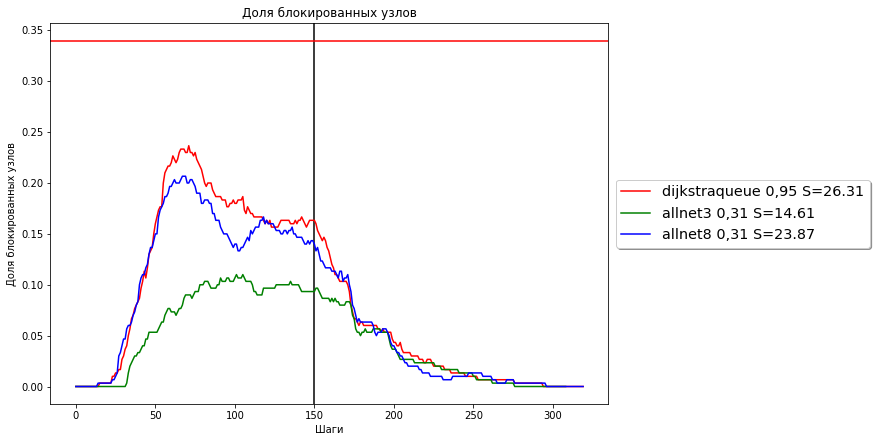

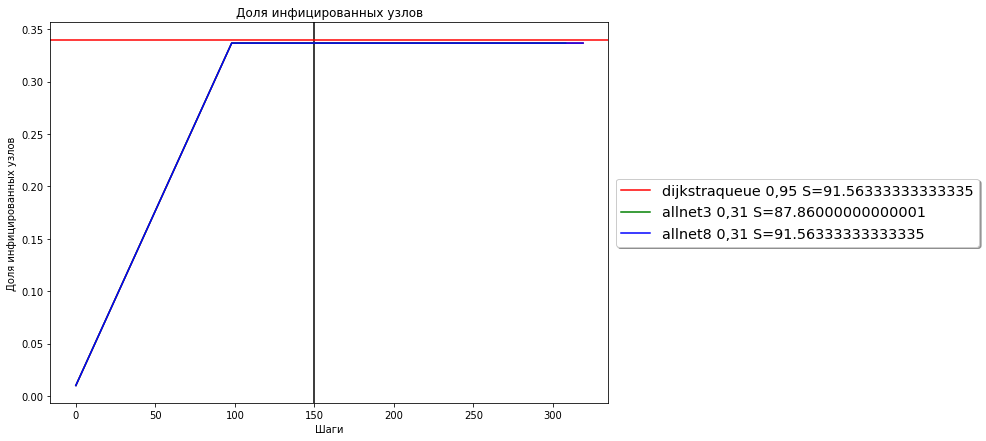

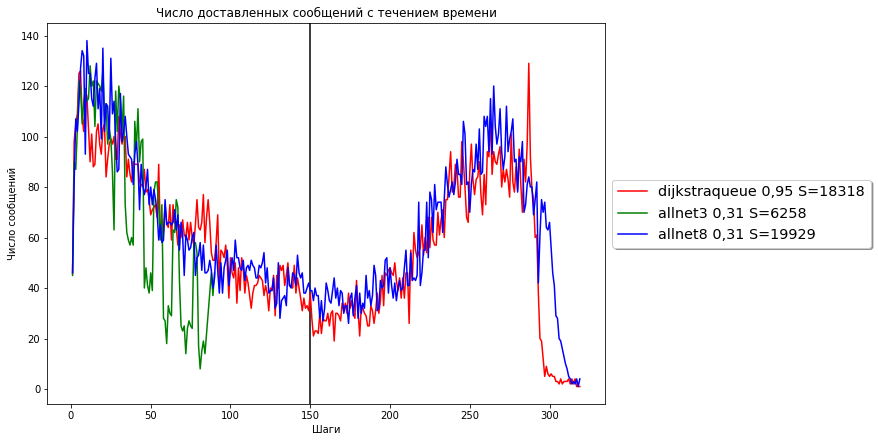

In [7]:
quantity = 300;
log_tags = [
{"tag":  "b4e4813a-42de-4517-8471-229d48293e1a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f95d260a-e037-4cd4-a9b2-e09a4165081e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "c5510e00-53cb-4494-bb6b-95bb784915fb", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "ddf78eb3-e2f6-48b9-9f4b-49197d9281ae", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "2140f59e-feeb-4f0a-aba9-8c252f8651d2", "label": "allnet3 0,31", "color": "green"},
{"tag":  "32110798-29bb-4254-8d9b-b48702e9feb9", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "5a591a41-c874-4714-8dad-2589b74ab97d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c308f853-f96d-40c0-95e8-baa8135bc15a", "label": "allnet3 0,31", "color": "green"},
{"tag":  "a9b589b2-0b0d-4791-b682-e5e7cd30d81d", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "bd77b76b-b292-4b40-ba21-e14d7e47168b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "24a81a34-f4ba-45d2-828d-1eb59994f63b", "label": "allnet3 0,31", "color": "green"},
{"tag":  "37d21872-aa5a-4f73-ad55-0e35c2de9052", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,31  allnet8 0,31
100             3.096460      1.947603      3.177921
300            18.988022      4.798027     16.622631
500            36.686271      8.859135     36.081852
700            36.323692     13.302588     36.817916
900            36.206754     15.661003     36.985245
1000           31.301231     17.457257     34.965614
1300           33.410988     23.141199     34.568192
1500           35.861547     28.229132     35.617402


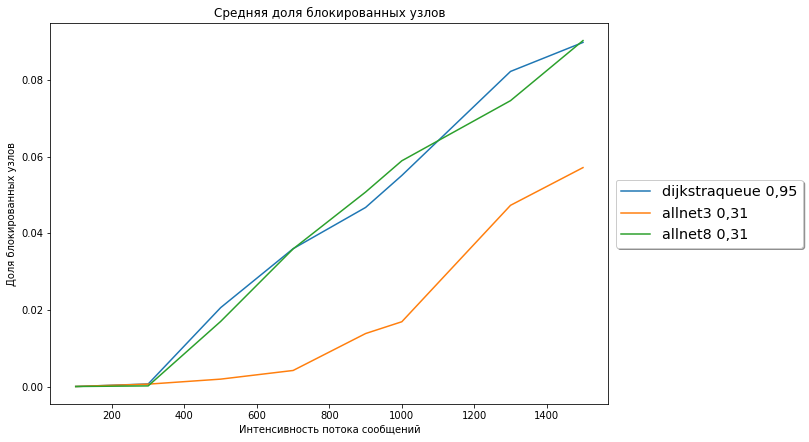

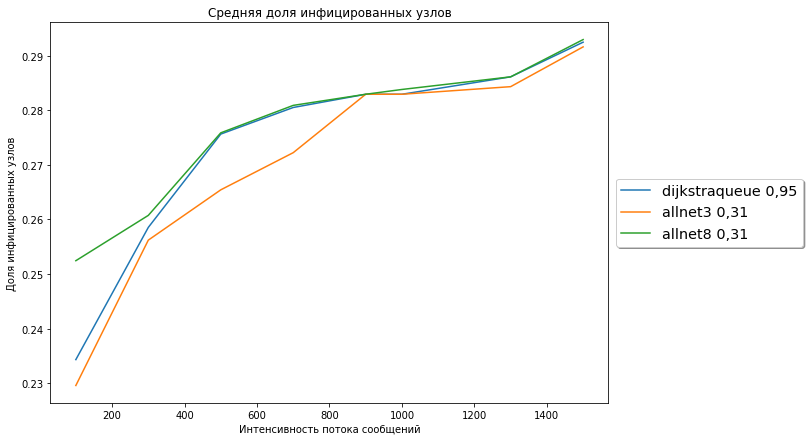

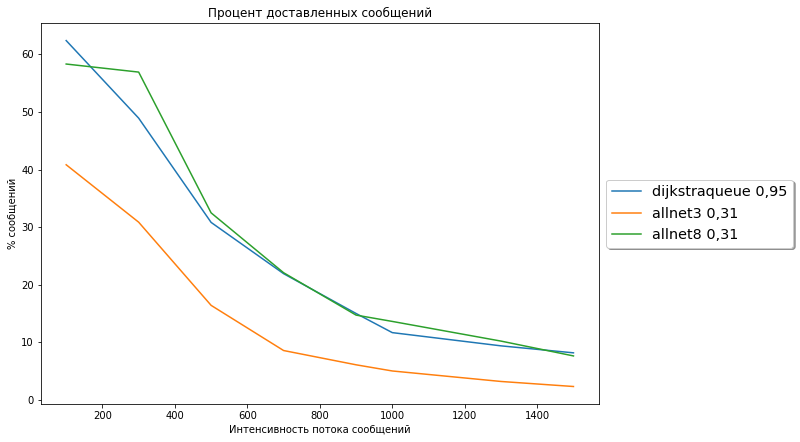

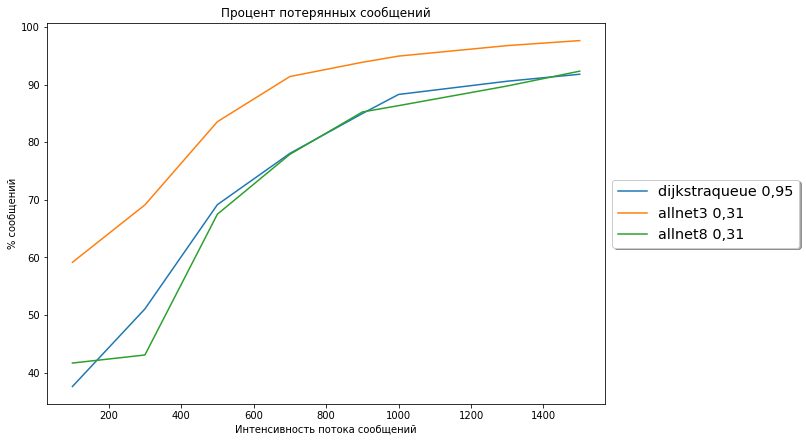

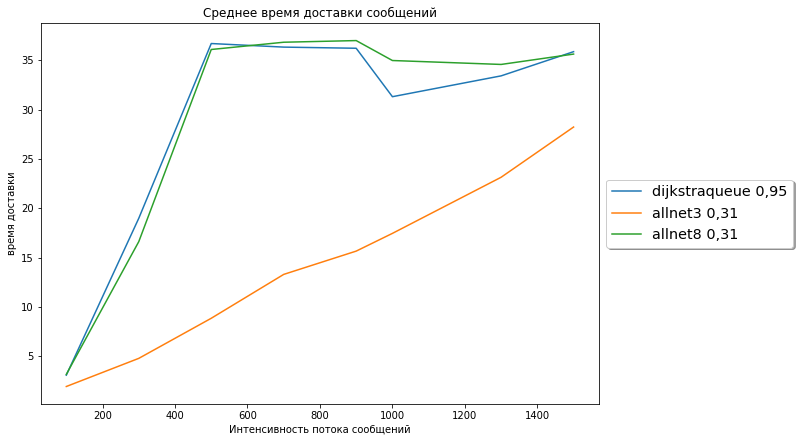

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.041375
allnet3 0,31          0.017730
allnet8 0,31          0.040944

dijkstraqueue 0,95    73.953005
allnet3 0,31          85.825946
allnet8 0,31          72.990965

dijkstraqueue 0,95    28.984371
allnet3 0,31          14.174493
allnet8 0,31          29.354597

dijkstraqueue 0,95    0.274195
allnet3 0,31          0.270666
allnet8 0,31          0.276982
